In [1]:
import sys, os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [2]:
# from src.generator import data_generator, clip_generator, label_generator
from src.data import data_generator
from src.util import characters, id_from_char, char_from_id
from src.export import display_progress

from pymongo import MongoClient
from tensorflow import keras

import numpy as np
import pickle

In [3]:
for character in characters:
    print(character)

CAPTAIN_FALCON
DONKEY_KONG
FOX
GAME_AND_WATCH
KIRBY
BOWSER
LINK
LUIGI
MARIO
MARTH
MEWTWO
NESS
PEACH
PIKACHU
ICE_CLIMBERS
JIGGLYPUFF
SAMUS
YOSHI
ZELDA
SHEIK
FALCO
YOUNG_LINK
DR_MARIO
ROY
PICHU
GANONDORF


# The Model

Source code for model creation is in src/models.py

In [4]:
polynomial_schedule = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = .1,
    end_learning_rate = .0001,
    decay_steps=100000,
    power=.5)

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries = [ 10000, 20000 ],
    values     = [.001, .0005, .0001 ])

In [49]:
from tensorflow.keras.optimizers import Adam, Nadam
adam = Adam(learning_rate=.0001)
nadam = Nadam(learning_rate=.0001)

In [50]:
# # to make a new model
# from src.models import custom_mk4 as Model
# model = Model()

# # to load the saved model
# model = keras.models.load_model('../models/custom_mk2')

from src.models import focal_loss, top_8_accuracy
model.compile(loss=focal_loss,
              optimizer=adam,
              metrics=['accuracy', top_8_accuracy])

In [7]:
model.summary()

Model: "custom_mk4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, None, 150)         58650     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 150)         600       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 150)         0         
_________________________________________________________________
conv2 (Conv1D)               (None, None, 256)         576256    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 256)         1024      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
conv3 (Conv1D)               (None, None, 512)         1

# Testing

In [52]:
data_test = data_generator(input_directory='../data/test',
                           batch_size = 25,
                           num_batches = 100,
                           shuffle=True)

In [53]:
score = model.evaluate(data_test, verbose=1)

print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 categorical accuracy: {round(score[2]*100)}%') 

100/100 [==============================] - 7s 75ms/step - loss: 0.0284 - accuracy: 0.9500 - top 8 accuracy: 0.9820

Test score: 0.028
Test accuracy: 95%
Test test top 8 categorical accuracy: 98%


# Confusion Matrix

In [54]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [55]:
def get_conf_matrix(labels_as_id, predictions_as_id):
    conf_matrix = np.zeros((27,27))
    for i_real, i_pred in zip(labels_as_id, predictions_as_id):
        conf_matrix[i_real, i_pred] += 1
    return conf_matrix

In [56]:
num_batches = 100
data_test = data_generator(input_directory='../data/test',
                           batch_size = 100,
                           num_batches = num_batches,
                           shuffle=True,
                           onehot=False)

In [57]:
recalls = {k:0 for k in range(1,27)}
precisions = {k:0 for k in range(1,27)}

batch_preds = []
batch_labels = []
i = 0

for xi, yi in data_test:
    batch_preds.append(np.argmax(model.predict(xi), axis=1))
    batch_labels.append(yi)
    
    i+=1
    display_progress(i, num_batches)
display_progress(num_batches, num_batches)
    
pred = np.concatenate(batch_preds)
labels = np.concatenate(batch_labels)

conf_matrix = get_conf_matrix(labels, pred)
conf_df = pd.DataFrame(conf_matrix[1:,1:], index=characters, columns=characters)

[####################] 100 of 100 - 100.0% 

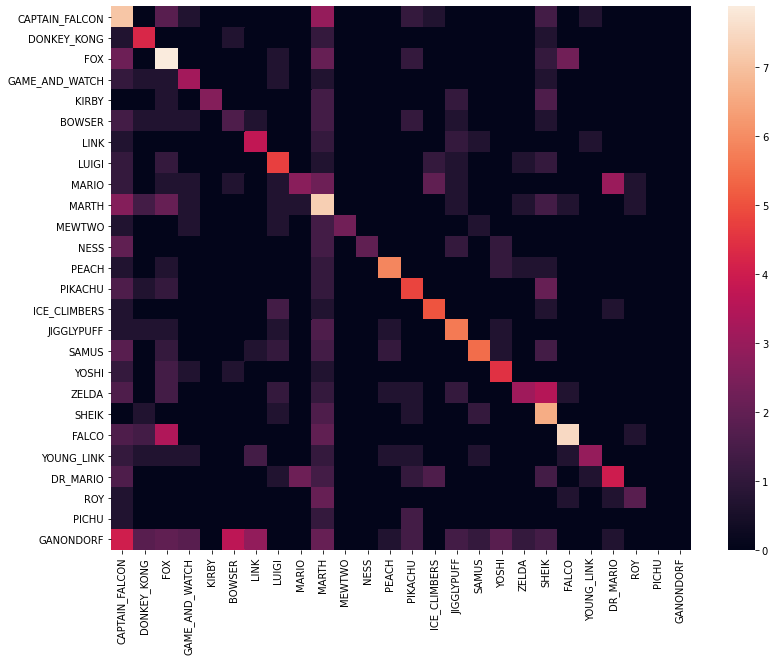

In [58]:
# sn.heatmap(conf_df, annot=False, mask=conf_df <= 0, cmap='viridis')
fig, ax = plt.subplots(figsize=(13,10))
sn.heatmap(np.log(1 + conf_df), annot=False, ax=ax, square=False)
fig.savefig('../images/confusion_matrix.png')

# Training

In [8]:
# Define Data generation
data_train = data_generator(input_directory='../data/train',
                            batch_size = 32,
                            shuffle=True,
                            repeat=True)

In [9]:
# Training Loop
model.fit(data_train,
          epochs=10,
          steps_per_epoch=1000,
          verbose=1)

score = model.evaluate(data_train, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/10
1000/1000 [==============================] - 524s 524ms/step - loss: 0.2823 - accuracy: 0.5980 - top 8 accuracy: 0.9073
Epoch 2/10
1000/1000 [==============================] - 513s 513ms/step - loss: 0.1558 - accuracy: 0.7815 - top 8 accuracy: 0.9516
Epoch 3/10
1000/1000 [==============================] - 515s 515ms/step - loss: 0.1228 - accuracy: 0.8251 - top 8 accuracy: 0.9607
Epoch 4/10
1000/1000 [==============================] - 515s 515ms/step - loss: 0.1013 - accuracy: 0.8544 - top 8 accuracy: 0.9681
Epoch 5/10
1000/1000 [==============================] - 514s 514ms/step - loss: 0.0881 - accuracy: 0.8706 - top 8 accuracy: 0.9704
Epoch 6/10
1000/1000 [==============================] - 514s 514ms/step - loss: 0.0825 - accuracy: 0.8778 - top 8 accuracy: 0.9703
Epoch 7/10
1000/1000 [==============================] - 513s 513ms/step - loss: 0.0783 - accuracy: 0.8829 - top 8 accuracy: 0.9724
Epoch 8/10
1000/1000 [==============================] - 519s 519ms/step - loss: 0.0

In [10]:
# Define Data generation
data_train = data_generator(input_directory='../data/train',
                            batch_size = 64,
                            shuffle=True,
                            repeat=True)

In [11]:
# Training Loop
model.fit(data_train,
          epochs=10,
          steps_per_epoch=500,
          verbose=1)

score = model.evaluate(data_train, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/10
500/500 [==============================] - 527s 1s/step - loss: 0.0565 - accuracy: 0.9114 - top 8 accuracy: 0.9761
Epoch 2/10
500/500 [==============================] - 533s 1s/step - loss: 0.0555 - accuracy: 0.9115 - top 8 accuracy: 0.9770
Epoch 3/10
500/500 [==============================] - 525s 1s/step - loss: 0.0524 - accuracy: 0.9157 - top 8 accuracy: 0.9755
Epoch 4/10
500/500 [==============================] - 522s 1s/step - loss: 0.0519 - accuracy: 0.9163 - top 8 accuracy: 0.9785
Epoch 5/10
500/500 [==============================] - 523s 1s/step - loss: 0.0503 - accuracy: 0.9183 - top 8 accuracy: 0.9755
Epoch 6/10
500/500 [==============================] - 525s 1s/step - loss: 0.0503 - accuracy: 0.9181 - top 8 accuracy: 0.9779
Epoch 7/10
500/500 [==============================] - 524s 1s/step - loss: 0.0495 - accuracy: 0.9207 - top 8 accuracy: 0.9764
Epoch 8/10
500/500 [==============================] - 523s 1s/step - loss: 0.0491 - accuracy: 0.9214 - top 8 accuracy:

In [40]:
# Define Data generation
data_train = data_generator(input_directory='../data/train',
                            batch_size = 64,
                            shuffle=True,
                            repeat=True)

In [41]:
# Training Loop
model.fit(data_train,
          epochs=5,
          steps_per_epoch=500,
          verbose=1)

score = model.evaluate(data_train, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/5
500/500 [==============================] - 528s 1s/step - loss: 0.0389 - accuracy: 0.9337 - top 8 accuracy: 0.9804
Epoch 2/5
500/500 [==============================] - 527s 1s/step - loss: 0.0387 - accuracy: 0.9327 - top 8 accuracy: 0.9798
Epoch 3/5
500/500 [==============================] - 526s 1s/step - loss: 0.0383 - accuracy: 0.9335 - top 8 accuracy: 0.9811
Epoch 4/5
500/500 [==============================] - 527s 1s/step - loss: 0.0397 - accuracy: 0.9319 - top 8 accuracy: 0.9788
Epoch 5/5
500/500 [==============================] - 526s 1s/step - loss: 0.0399 - accuracy: 0.9320 - top 8 accuracy: 0.9801

Test score: 0.034
Test accuracy: 94%
Test test top 8 accuracy: 98%


---

Changed learning rate to `.0001`

In [40]:
# Define Data generation
data_train = data_generator(input_directory='../data/train',
                            batch_size = 128,
                            shuffle=True,
                            repeat=True)

In [51]:
# Training Loop
model.fit(data_train,
          epochs=5,
          steps_per_epoch=250,
          verbose=1)

score = model.evaluate(data_train, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/5
250/250 [==============================] - 263s 1s/step - loss: 0.0362 - accuracy: 0.9374 - top 8 accuracy: 0.9814
Epoch 2/5
250/250 [==============================] - 264s 1s/step - loss: 0.0338 - accuracy: 0.9398 - top 8 accuracy: 0.9819
Epoch 3/5
250/250 [==============================] - 264s 1s/step - loss: 0.0370 - accuracy: 0.9361 - top 8 accuracy: 0.9796
Epoch 4/5
250/250 [==============================] - 263s 1s/step - loss: 0.0353 - accuracy: 0.9387 - top 8 accuracy: 0.9819
Epoch 5/5
250/250 [==============================] - 264s 1s/step - loss: 0.0328 - accuracy: 0.9426 - top 8 accuracy: 0.9834

Test score: 0.026
Test accuracy: 95%
Test test top 8 accuracy: 98%


In [39]:
model.save('../models/custom_mk4')